### Phylogenetic Tree construction 

> This notebook reads fungal species data from an Excel file, retrieves their taxonomy information, and generates a color-coded circular phylogenetic tree based on their classes.

In [ ]:
import pandas as pd
from ete3 import NCBITaxa, Tree, TreeStyle, NodeStyle, TextFace
from Bio import Phylo
from io import StringIO
import random

# -----------------------------------------
# Load the Excel File
# -----------------------------------------
file_path = "FungiExp_summary.xlsx"
df = pd.read_excel(file_path)

# Fill missing class names (forward fill to avoid NA issues)
df['class'] = df['class'].ffill()

# Initialize NCBI Taxonomy
ncbi = NCBITaxa()

# Get species-class mapping
species_class_map = df.set_index("Species")["class"].to_dict()
all_species = df["Species"].dropna().tolist()

# -----------------------------------------
# Retrieve Taxonomy Information
# -----------------------------------------
taxid_to_species = {}
species_to_taxid = {}
taxids = []

for species in all_species:
    taxid = ncbi.get_name_translator([species])
    if species in taxid:
        taxid_value = taxid[species][0]
        taxids.append(taxid_value)
        taxid_to_species[str(taxid_value)] = species
        species_to_taxid[species] = str(taxid_value)

# -----------------------------------------
# Generate Phylogenetic Tree
# -----------------------------------------
if len(taxids) > 1:
    # Get tree from NCBI
    tree = ncbi.get_topology(taxids)
    newick_tree = tree.write()

       # Save the Newick tree to a file
    with open("phylogenetic_tree_circular.nwk", "w") as file:
        file.write(newick_tree)


    # Convert to Biopython format
    tree_handle = StringIO(newick_tree)
    phylo_tree = Phylo.read(tree_handle, "newick")

    # Rename Taxonomy IDs to Species Names
    for clade in phylo_tree.get_terminals():
        species_name = taxid_to_species.get(clade.name, clade.name)
        clade.name = species_name  # Replace ID with species name

    # -----------------------------------------
    # Convert Biopython Tree to ETE3 Format
    # -----------------------------------------
    def convert_to_ete3(clade):
        """ Recursively convert a Biopython tree to an ETE3 tree """
        ete_tree = Tree()
        ete_tree.name = clade.name if clade.name else ""

        for child in clade.clades:
            child_tree = convert_to_ete3(child)
            ete_tree.add_child(child=child_tree, name=child.name, dist=child.branch_length)

        return ete_tree

    ete_tree = convert_to_ete3(phylo_tree.root)

    # -----------------------------------------
    # Colorize Tree Based on Fungal Classes
    # -----------------------------------------
    class_list = df["class"].dropna().unique().tolist()
    class_colors = {cls: f"#{random.randint(0, 0xFFFFFF):06x}" for cls in class_list}  # Random colors

    for node in ete_tree.traverse():
        if node.is_leaf():
            species_name = node.name
            # node.img_style["size"] = node_size
            # name_face = TextFace(species_name, fgcolor="black", fsize=label_size)
            if species_name in species_class_map:

                class_name = species_class_map[species_name]
                node_color = class_colors.get(class_name, "#000000")  # Default to black if missing

                # Style node
                style = NodeStyle()
                style["fgcolor"] = node_color
                style["size"] = 10
                node.set_style(style)

    # -----------------------------------------
    # Define Circular Tree Style
    # -----------------------------------------
    ts = TreeStyle()
    ts.mode = "c"  # Circular layout
    ts.show_leaf_name = True
    
    ts.arc_start = -90  # Start at the top (12 o'clock)
    ts.arc_span = 360  # Full circular tree
    
    ts.show_leaf_name = True
    
    # -----------------------------------------
    # Display Circular Phylogenetic Tree
    # -----------------------------------------
    ete_tree.show(tree_style=ts)

else:
    print("Not enough valid species found. Try checking missing species in NCBI.")


: 

## Assessing GEO vs FungiExp 
The aim of this is to check if the TPM values in FungiExp align closely with the RPKM of the GEO dataset. This is achieved through correlation of TPM and RPKM values of the same geneId.

#### Why log transform?
When working with gene expression data (such as RPKM, TPM, or FPKM), the distribution of expression levels is typically highly skewed, with many genes having very low expression counts and a few genes having very high counts.

**Taking a log transform helps in several ways:**

- Normalizes the Scale: By applying a log transform, extreme high values are compressed, and smaller values are spread out a bit more. This makes it easier to see variations across the entire range of expression levels.
- Reduces Skewness: Gene expression data often spans multiple orders of magnitude. The log transform can produce a distribution that is closer to normal (Gaussian), allowing for more robust statistical analyses and clearer visual patterns.


#### Interpreation 
- A high correlation (close to 1.0) means RPKM and TPM track closely.
- Because of differences in how RPKM and TPM are calculated, it’s normal  for their magnitudes to differ, but they should still be highly correlated.


(6319, 6)

Pearson correlation between RPKM and TPM: 0.9979
Spearman correlation between RPKM and TPM: 0.9984
R² score between RPKM and TPM: 0.9794


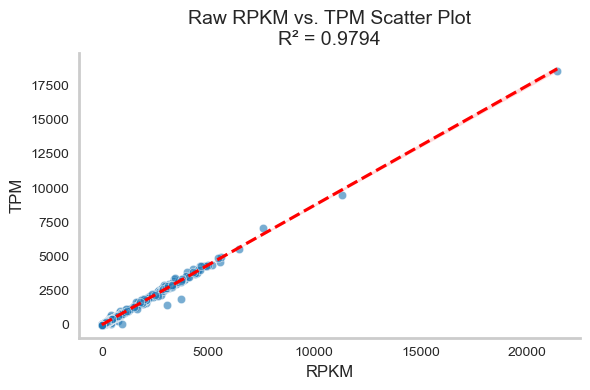

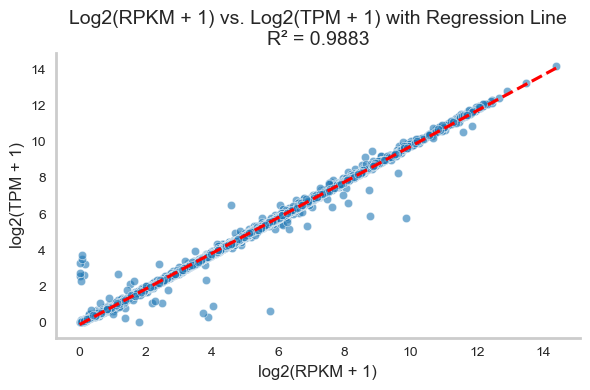

In [ ]:
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.metrics import r2_score


directory_geo_fungiexp = "./22_2_25_GEO_fungiexp_test"
txt_file_path = f"{directory_geo_fungiexp}/YL1_GSM3914229_WT-RNA.txt"
tsv_file_path = f"{directory_geo_fungiexp}/YL1_WT_SRX6386859.gene.expr.tsv"

df_txt = pd.read_csv(txt_file_path, sep="\t")
df_txt = df_txt.rename(columns={"GeneName": "geneId"}) #rename column to match the TSV file
df_tsv = pd.read_csv(tsv_file_path, sep="\t")

df_tsv["geneId"] = df_tsv["geneId"].str.replace("_", "", regex=False) # Remove underscores from 'geneId' column in the TSV file
merged_df = pd.merge(df_txt, df_tsv, on="geneId", how="inner") # Merge the DataFrames on the 'geneId' column, keeping only matching rows

# Remove any rows where RPKM or TPM is missing or zero (to avoid log issues)
merged_df = merged_df.dropna(subset=["RPKM", "TPM"])
merged_df = merged_df[(merged_df["RPKM"] > 0) & (merged_df["TPM"] > 0)]
print(merged_df.shape)


r2 = r2_score(merged_df["RPKM"], merged_df["TPM"])
# Compute Pearson correlation
corr_pearson = merged_df[["RPKM", "TPM"]].corr(method='pearson').iloc[0,1]
# Compute Spearman correlation
corr_spearman = merged_df[["RPKM", "TPM"]].corr(method='spearman').iloc[0,1]
print(f"\nPearson correlation between RPKM and TPM: {corr_pearson:.4f}")
print(f"Spearman correlation between RPKM and TPM: {corr_spearman:.4f}")
print(f"R² score between RPKM and TPM: {r2:.4f}")

# ------------------------------------------------------------------------------
# 4) VISUALIZE THE RELATIONSHIP (Scatter Plots)
# ------------------------------------------------------------------------------
sns.set_style("whitegrid")

# (A) RAW VALUES
plt.figure(figsize=(6, 4))
sns.scatterplot(data=merged_df, x="RPKM", y="TPM", alpha=0.6)
sns.regplot(data=merged_df, x="RPKM", y="TPM", scatter=False, line_kws={"color": "red", "linestyle": "dashed"})
r2_raw = r2_score(merged_df["RPKM"], merged_df["TPM"])
plt.title(f"Raw RPKM vs. TPM Scatter Plot\nR² = {r2_raw:.4f}", fontsize=14)
plt.xlabel("RPKM", fontsize=12)
plt.ylabel("TPM", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.gca().spines['bottom'].set_linewidth(2)
plt.gca().spines['left'].set_linewidth(2)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.tight_layout()
plt.grid(False)
plt.show()

# (B) LOG-SCALED VALUES
# Adding 1 to avoid log(0) if any values are extremely small or zero.
merged_df["log_RPKM"] = np.log2(merged_df["RPKM"] + 1)
merged_df["log_TPM"] = np.log2(merged_df["TPM"] + 1)

plt.figure(figsize=(6, 4))
sns.scatterplot(data=merged_df, x="log_RPKM", y="log_TPM", alpha=0.6)
sns.regplot(data=merged_df, x="log_RPKM", y="log_TPM", scatter=False, line_kws={"color": "red", "linestyle": "dashed"})
r2_log = r2_score(merged_df["log_RPKM"], merged_df["log_TPM"])
plt.title(f"Log2(RPKM + 1) vs. Log2(TPM + 1) with Regression Line\nR² = {r2_log:.4f}", fontsize=14)
plt.xlabel("log2(RPKM + 1)", fontsize=12)
plt.ylabel("log2(TPM + 1)", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.gca().spines['bottom'].set_linewidth(2)
plt.gca().spines['left'].set_linewidth(2)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.tight_layout()
plt.grid(False)
plt.show()





## Overview of Taxon ID to Species Name Conversion

> This script reads fungal taxon IDs from an Excel file, retrieves their scientific names from the NCBI database, and saves the results to a CSV file.

In [11]:
import pandas as pd
from Bio import Entrez
from urllib.error import HTTPError
from http.client import IncompleteRead
import time

Entrez.email = "marc.amil@kcl.ac.uk"  # Use a valid email

df = pd.read_excel("FungiExp_dataset_downloaded.xlsx")
species_names = []

for tax_id in df["Taxon_ID"]:
    tax_id_str = str(tax_id).strip()

    if not tax_id_str or tax_id_str.lower() in ["nan", "na"]:
        species_names.append("Not found")
        continue

    attempts = 3  # Number of retries
    sci_name = "Not found"

    for attempt in range(attempts):
        try:
            handle = Entrez.efetch(db="taxonomy", id=tax_id_str, retmode="xml")
            records = Entrez.read(handle)
            if records:
                sci_name = records[0]["ScientificName"]
            break  # Success, exit retry loop

        except HTTPError as e:
            print(f"HTTP error for Taxon ID={tax_id_str}: {e}")
            time.sleep(0.5)  # Wait before retrying

        except IncompleteRead as e:
            print(f"Incomplete read error for Taxon ID={tax_id_str}, retrying...")
            time.sleep(1)  # Slightly longer wait before retrying

        except Exception as e:
            print(f"Unexpected error for Taxon ID={tax_id_str}: {e}")
            break  # Don't retry unknown errors

    species_names.append(sci_name)
    time.sleep(0.3)  # Small delay to avoid overloading NCBI

df["Species_name"] = species_names
df.to_csv("output_with_species.csv", index=False)

print("Done! Results saved to 'output_with_species.csv'.")


HTTP error for Taxon ID=759272: HTTP Error 400: Bad Request
Done! Results saved to 'output_with_species.csv'.


# Plotting Gene Expression From FungiExp 

- Take the TPM value from FungiExp for all the different organisms, 
- Filter the TPM data based on `low TPM values` (e.g. TPM > 5) and `high coefficient of variation (CV)` e.g. (CV < 1).
- This will be then used for a regression model.


In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import gffutils
import os
from Bio import SeqIO
import pandas as pd
import re
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from rnanorm.datasets import load_toy_data
from rnanorm import TPM
from scipy import stats
from pathlib import Path
import glob

/Users/marcamil/anaconda3/lib/python3.11/site-packages/pandera/engines/pandas_engine.py:67: UserWarning: Using typeguard < 3. Generic types like List[TYPE], Dict[TYPE, TYPE] will only validate the first element in the collection.
  warnings.warn(


- The code loads a mapping of taxon IDs to species names from a CSV file and identifies folders with numeric names as taxon IDs.
- It reads TSV files from these folders, extracts relevant columns, and combines the data into a single DataFrame.
- The combined DataFrame is filtered for positive TPM values, taxon IDs are replace with species names, and the result is saved as a CSV file.

In [20]:
import os
import glob
import pandas as pd

# Load the taxon ID to species name mapping
mapping_df = pd.read_csv("output_with_species.csv")
taxon_mapping = dict(zip(mapping_df['Taxon_ID'].astype(str), mapping_df['Species_name']))

all_dataframes = []
base_path = "/Users/marcamil/PhD/PhD_SyntheticGenomes/Projects/Transcriptional_unit_design_in_yeast/data/RNA_seq_fungal/trial_directory/"
taxon_folders = [f for f in os.listdir(base_path) if f.isdigit()]

# Loop through each taxon folder
for taxon in taxon_folders:
    folder_path = os.path.join(base_path, taxon)
    files = glob.glob(os.path.join(folder_path, "*.tsv"))

    for file_path in files:
        df = pd.read_csv(file_path, sep="\t", dtype=str)
        df = df[['geneId', 'TPM']]
        df['taxon'] = taxon
        all_dataframes.append(df)

combined_df = pd.concat(all_dataframes, ignore_index=True)

combined_df['TPM'] = pd.to_numeric(combined_df['TPM'], errors='coerce')
filtered_df = combined_df[combined_df['TPM'] > 0].copy()
filtered_df['taxon'] = filtered_df['taxon'].map(taxon_mapping).fillna('')
filtered_df.to_csv("filtered_df_python_2.csv", index=False)

# Save the resulting DataFrame as a CSV file for each species
for taxon, species_name in taxon_mapping.items():
    species_df = filtered_df[filtered_df['taxon'] == species_name]
    if not species_df.empty:
        species_name_formatted = species_name.replace(" ", "_")
        species_df.to_csv(f"filtered_df_{species_name_formatted}.csv", index=False)
        print(f"{species_name} {species_df.shape}")

# Print the result
print(filtered_df) 

Yarrowia lipolytica CLIB122 (2203510, 3)
Kluyveromyces lactis (331365, 3)
Ogataea polymorpha (321065, 3)
                   geneId         TPM                        taxon
1           YALI0_C11539g   65.293129  Yarrowia lipolytica CLIB122
2           YALI0_D18337g  142.171982  Yarrowia lipolytica CLIB122
3           YALI0_C02453g   44.556225  Yarrowia lipolytica CLIB122
4           YALI0_E06831g   23.918674  Yarrowia lipolytica CLIB122
5           YALI0_B17072g   65.826477  Yarrowia lipolytica CLIB122
...                   ...         ...                          ...
3312024  OGAPODRAFT_81366  210.116867           Ogataea polymorpha
3312026  OGAPODRAFT_46930  118.606880           Ogataea polymorpha
3312027  OGAPODRAFT_15818    0.021978           Ogataea polymorpha
3312028  OGAPODRAFT_15498   32.337154           Ogataea polymorpha
3312032   OGAPODRAFT_7383   41.227592           Ogataea polymorpha

[2855940 rows x 3 columns]


- The code defines a function to calculate the relative standard deviation (RSD) of a dataset.
- It filters a dataset based on TPM and RSD thresholds, returning median TPM values for genes meeting the criteria.
- The code also includes functions to transform TPM values using Box-Cox and Yeo-Johnson methods, and to plot the transformed data, optionally saving the results to a file.

In [ ]:
      
def rsd(x): 
    return x.std()/x.mean()

def filter_tpm_rsd_dataset(dataset, tpm_threshold, rsd_threshold):
    gene_stats = dataset.query('TPM > 0').groupby(['geneId']).agg({'TPM' :['sum', 'mean', 'median', 'std', rsd]})
    ge_data_tpm_median = dataset.query('TPM > {}'.format(tpm_threshold)).groupby("geneId").agg({'TPM': 'median'}).reset_index()
    ge_data_tpm_median_rsd = ge_data_tpm_median[ge_data_tpm_median["geneId"].isin(gene_stats["TPM"].query('rsd < {}'.format(rsd_threshold)).index)]
    return ge_data_tpm_median_rsd

def transform_tpm(dataset):
    boxcox_tpm, bc_lmbda = stats.boxcox(dataset["TPM"])
    dataset["boxcox_tpm"] = boxcox_tpm
    dataset["bc_lmbda"] = bc_lmbda
    yj_tpm, yj_lmbda = stats.yeojohnson(dataset["TPM"])
    dataset["yj_tpm"] = yj_tpm
    dataset["yj_lmbda"] = yj_lmbda
    
    return dataset

def plot_transformed(dataset, title, save_path=None): # save path should be .tsv
    if save_path is not None:
        dataset.to_csv(save_path, sep="\t", index=False)
    fig, axes = plt.subplots(1, 4, figsize=(15, 6), sharex=False, sharey=False)
    sns.set_theme()
    sns.histplot(ax=axes[0],  x="TPM", data=dataset).set(xlabel="TPM")
    sns.histplot(ax=axes[1],  x="TPM", data=dataset, log_scale=True).set(xlabel="TPM log scale")
    sns.histplot(ax=axes[2],  x="boxcox_tpm", data=dataset).set(xlabel="Boxcox transformed TPM")
    sns.histplot(ax=axes[3],  x="yj_tpm", data=dataset).set(xlabel="Yeo Johnson transformed TPM")
    fig.suptitle('dataset size: {}, {}'.format(dataset.shape[0], title))
    
    if save_path is not None:
        fig.savefig(save_path.replace(".tsv", ".png"), dpi=300)     


Processing Yarrowia lipolytica CLIB122 with shape (2203510, 3)
(2203510, 3)
          geneId         TPM                        taxon
0  YALI0_C11539g   65.293129  Yarrowia lipolytica CLIB122
1  YALI0_D18337g  142.171982  Yarrowia lipolytica CLIB122
2  YALI0_C02453g   44.556225  Yarrowia lipolytica CLIB122
3  YALI0_E06831g   23.918674  Yarrowia lipolytica CLIB122
4  YALI0_B17072g   65.826477  Yarrowia lipolytica CLIB122
TPM > 0
TPM > 1
TPM > 2
TPM > 3
TPM > 4
TPM > 5
   index       rsd  tmp_threshold
4    50%  0.711953              0
5    60%  0.875228              0
6    70%  1.105998              0
7    75%  1.266168              0
8    80%  1.502993              0
9    90%  2.113798              0
10   95%  2.820937              0
11   99%  5.076091              0
4    50%  0.632598              1
5    60%  0.714590              1
6    70%  0.856231              1
7    75%  0.948177              1
8    80%  1.067542              1
9    90%  1.560384              1
10   95%  2.164198

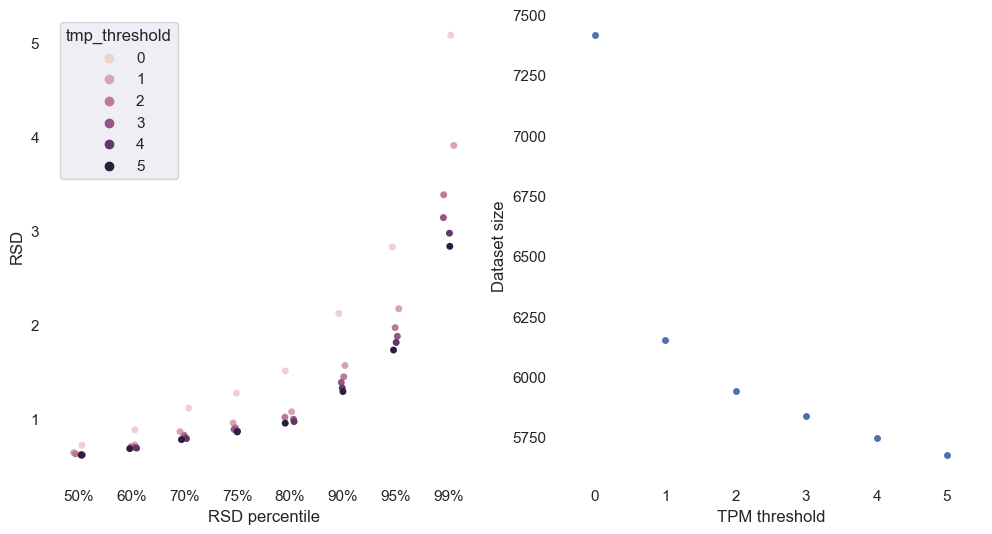

{'Transformation': ['Box-Cox TPM', 'Yeo-Johnson TPM'], 'Skewness': [0.0186566367731752, 0.026349292460926006], 'Kurtosis': [-0.2804667545051198, -0.34138764484311324]}


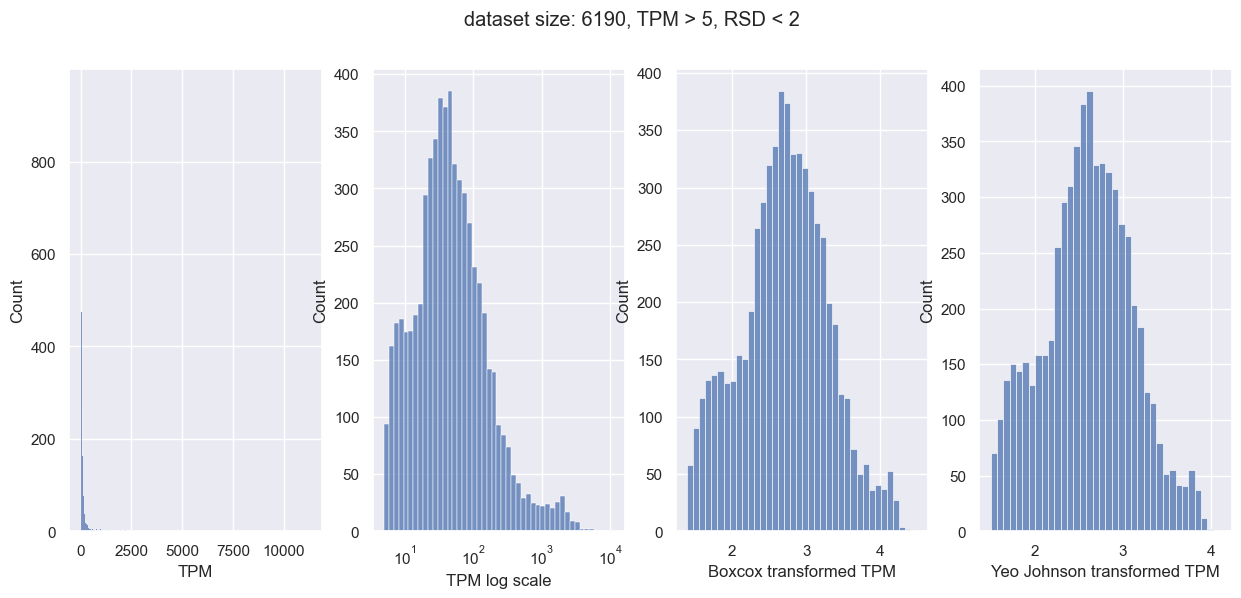

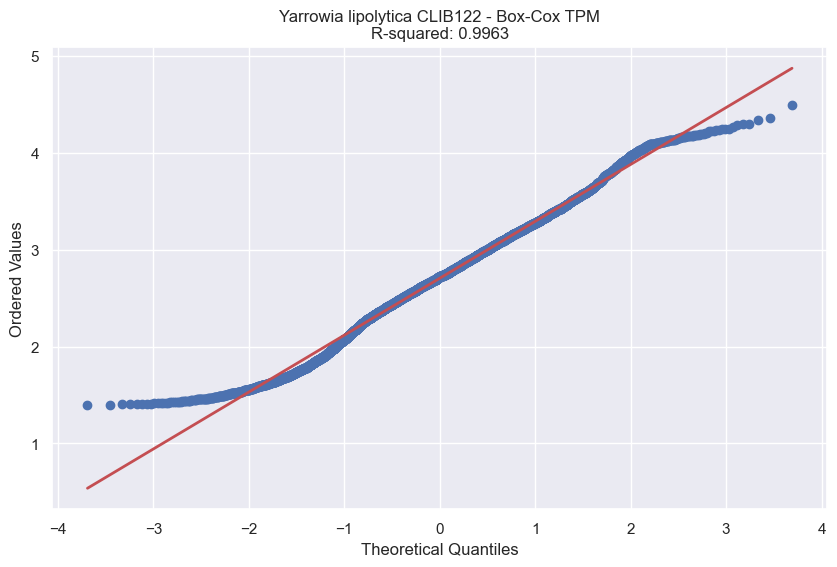

Processing Kluyveromyces lactis with shape (331365, 3)
(331365, 3)
          geneId         TPM                 taxon
0  KLLA0_B04158g  142.978073  Kluyveromyces lactis
1  KLLA0_F07293g  105.379051  Kluyveromyces lactis
2  KLLA0_D17765r    0.235061  Kluyveromyces lactis
3  KLLA0_E08163g   31.695118  Kluyveromyces lactis
4  KLLA0_D07029g   23.085102  Kluyveromyces lactis
TPM > 0
TPM > 1
TPM > 2
TPM > 3
TPM > 4
TPM > 5
   index       rsd  tmp_threshold
4    50%  0.853626              0
5    60%  0.948148              0
6    70%  1.063844              0
7    75%  1.135926              0
8    80%  1.211109              0
9    90%  1.560397              0
10   95%  2.258030              0
11   99%  4.469070              0
4    50%  0.842480              1
5    60%  0.934816              1
6    70%  1.041007              1
7    75%  1.109220              1
8    80%  1.180086              1
9    90%  1.451540              1
10   95%  1.948903              1
11   99%  3.870609              1
4

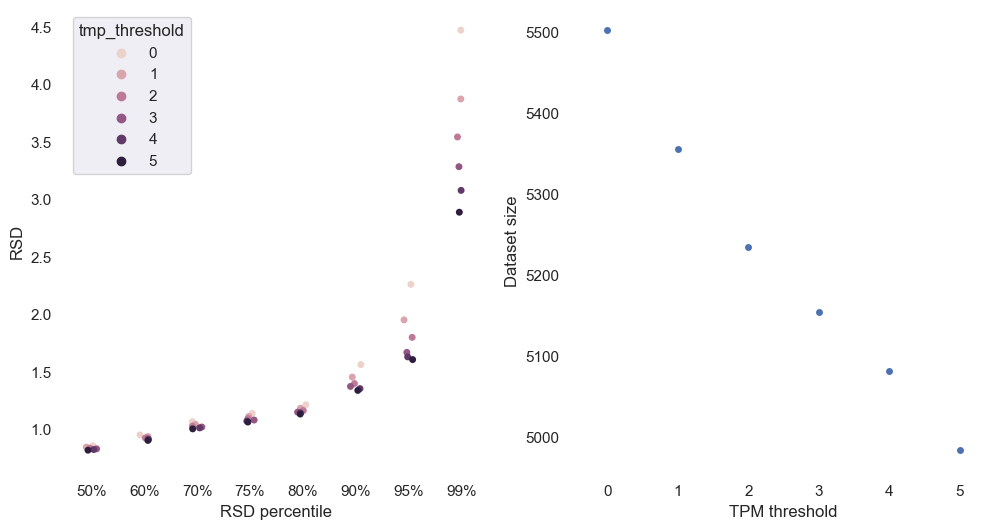

{'Transformation': ['Box-Cox TPM', 'Yeo-Johnson TPM'], 'Skewness': [0.034735285974851364, 0.04725772754591272], 'Kurtosis': [-0.223175176557044, -0.2963027907093476]}


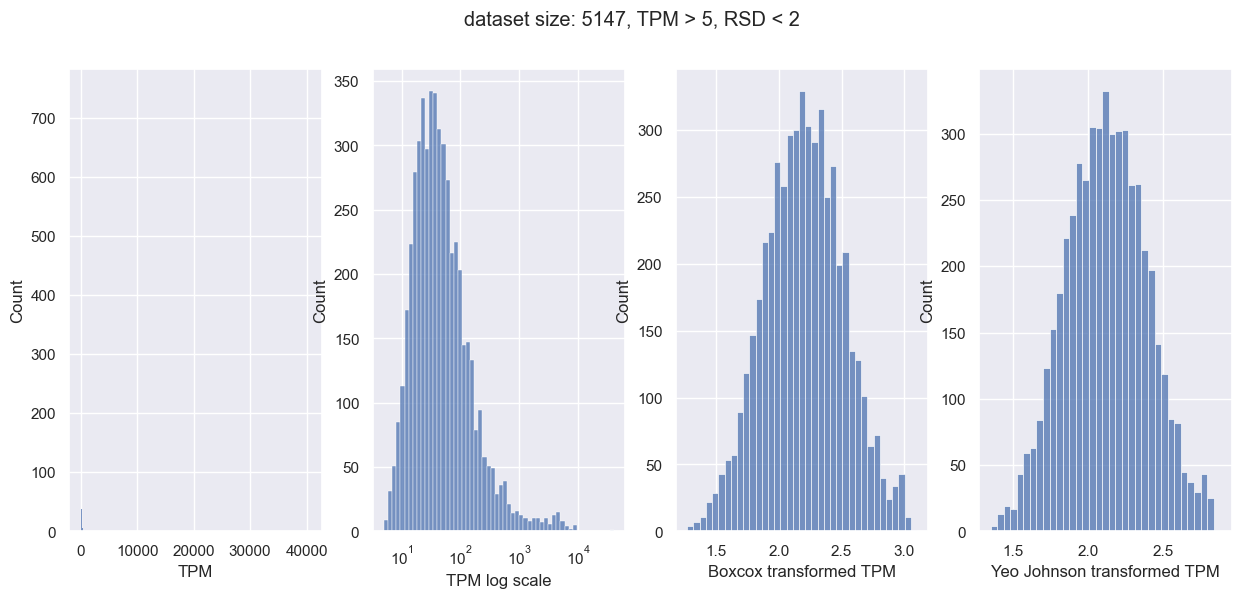

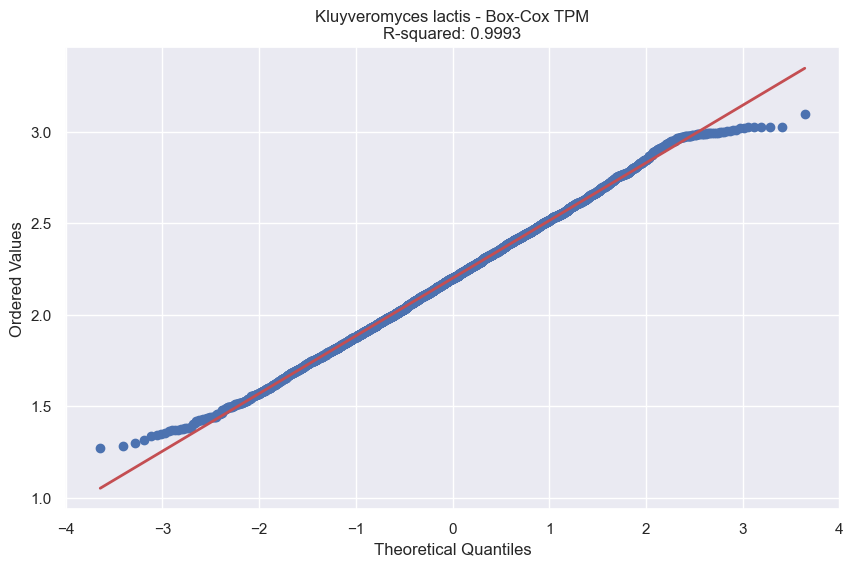

Processing Ogataea polymorpha with shape (321065, 3)
(321065, 3)
             geneId        TPM               taxon
0  OGAPODRAFT_17585  64.040611  Ogataea polymorpha
1  OGAPODRAFT_94498   3.650870  Ogataea polymorpha
2  OGAPODRAFT_94336  47.726917  Ogataea polymorpha
3  OGAPODRAFT_94818  41.702225  Ogataea polymorpha
4  OGAPODRAFT_48361  94.509537  Ogataea polymorpha
TPM > 0
TPM > 1
TPM > 2
TPM > 3
TPM > 4
TPM > 5
   index       rsd  tmp_threshold
4    50%  0.649997              0
5    60%  0.751770              0
6    70%  0.877081              0
7    75%  0.959901              0
8    80%  1.061364              0
9    90%  1.344932              0
10   95%  1.636227              0
11   99%  2.539918              0
4    50%  0.628249              1
5    60%  0.718511              1
6    70%  0.836278              1
7    75%  0.913370              1
8    80%  1.005124              1
9    90%  1.274589              1
10   95%  1.503875              1
11   99%  2.277838              1
4  

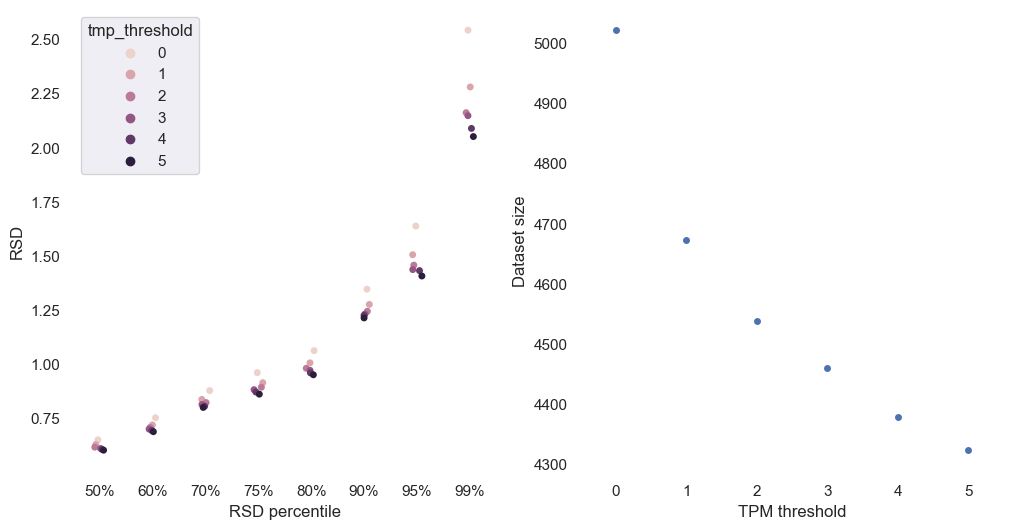

{'Transformation': ['Box-Cox TPM', 'Yeo-Johnson TPM'], 'Skewness': [0.011441991323503965, 0.01656058952784137], 'Kurtosis': [-0.2937941547546732, -0.3545669728073393]}


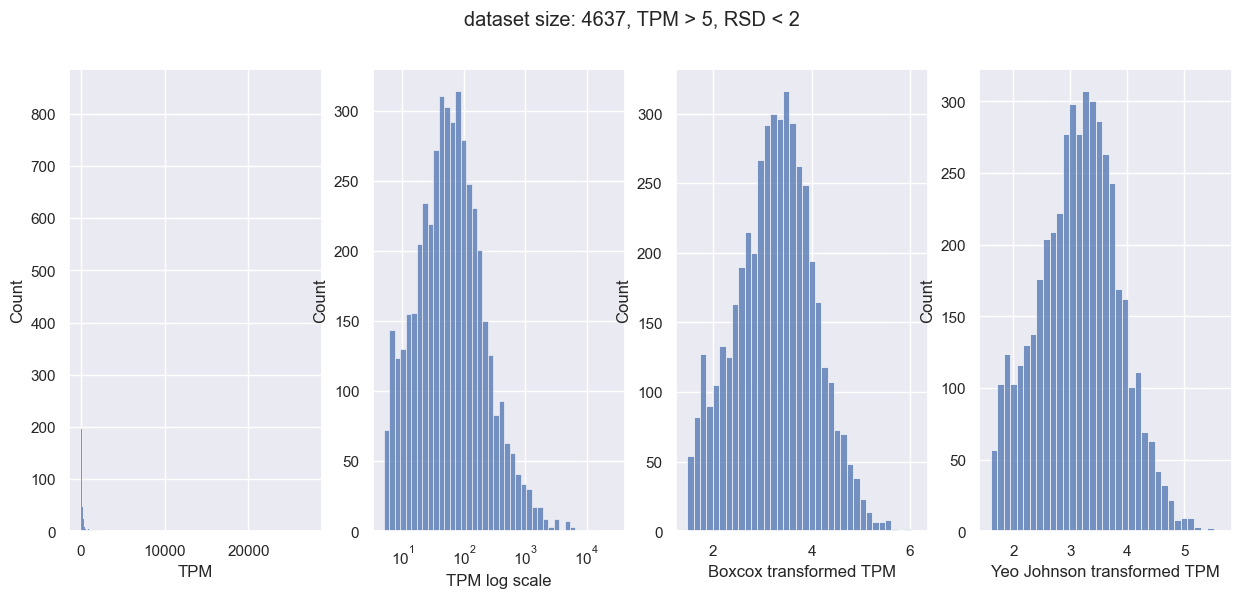

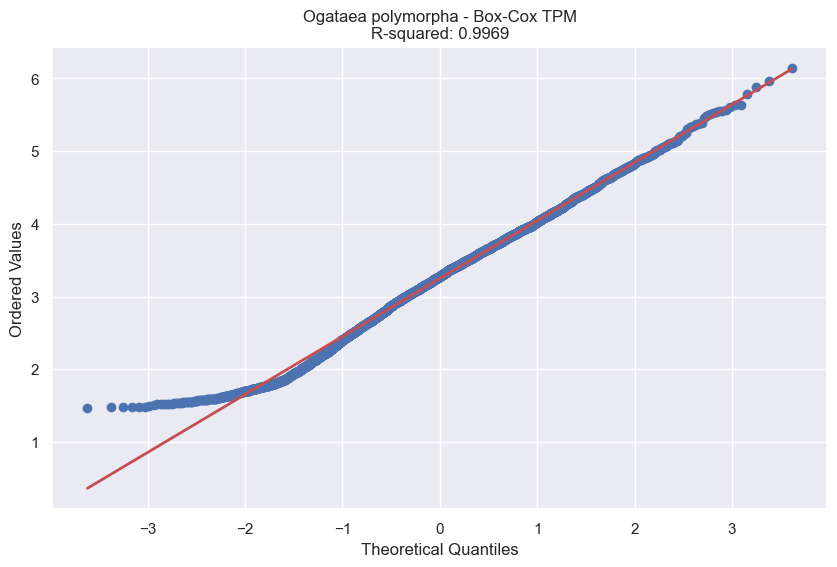

In [40]:
# Define the thresholds
TPM_THRESHOLD = 5
RSD_THRESHOLD = 2

# Define the functions
def rsd(x): 
    return x.std()/x.mean()

def filter_tpm_rsd_dataset(dataset, tpm_threshold, rsd_threshold):
    gene_stats = dataset.query('TPM > 0').groupby(['geneId']).agg({'TPM' :['sum', 'mean', 'median', 'std', rsd]})
    ge_data_tpm_median = dataset.query('TPM > {}'.format(tpm_threshold)).groupby("geneId").agg({'TPM': 'median'}).reset_index()
    ge_data_tpm_median_rsd = ge_data_tpm_median[ge_data_tpm_median["geneId"].isin(gene_stats["TPM"].query('rsd < {}'.format(rsd_threshold)).index)]
    return ge_data_tpm_median_rsd

def transform_tpm(dataset):
    boxcox_tpm, bc_lmbda = stats.boxcox(dataset["TPM"])
    dataset["boxcox_tpm"] = boxcox_tpm
    dataset["bc_lmbda"] = bc_lmbda
    yj_tpm, yj_lmbda = stats.yeojohnson(dataset["TPM"])
    dataset["yj_tpm"] = yj_tpm
    dataset["yj_lmbda"] = yj_lmbda
    
    return dataset

def plot_transformed(dataset, title, save_path=None): # save path should be .tsv
    if save_path is not None:
        dataset.to_csv(save_path, sep="\t", index=False)
    fig, axes = plt.subplots(1, 4, figsize=(15, 6), sharex=False, sharey=False)
    sns.set_theme()
    sns.histplot(ax=axes[0],  x="TPM", data=dataset).set(xlabel="TPM")
    sns.histplot(ax=axes[1],  x="TPM", data=dataset, log_scale=True).set(xlabel="TPM log scale")
    sns.histplot(ax=axes[2],  x="boxcox_tpm", data=dataset).set(xlabel="Boxcox transformed TPM")
    sns.histplot(ax=axes[3],  x="yj_tpm", data=dataset).set(xlabel="Yeo Johnson transformed TPM")
    fig.suptitle('dataset size: {}, {}'.format(dataset.shape[0], title))
    
    if save_path is not None:
        fig.savefig(save_path.replace(".tsv", ".png"), dpi=300)     


# Load the taxon ID to species name mapping
mapping_df = pd.read_csv("output_with_species.csv")
taxon_mapping = dict(zip(mapping_df['Taxon_ID'].astype(str), mapping_df['Species_name']))

# Loop through each species CSV file and perform the analysis
for taxon, species_name in taxon_mapping.items():
    species_name_formatted = species_name.replace(" ", "_")
    file_path = f"filtered_df_{species_name_formatted}.csv"
    
    if os.path.exists(file_path):
        filtered_df = pd.read_csv(file_path, sep=",")
        filtered_df = filtered_df.dropna()
        filtered_df = filtered_df.replace([np.inf, -np.inf], np.nan).dropna() # Replace infinite values with NaN and then drop them
        
        print(f"Processing {species_name} with shape {filtered_df.shape}")
        print(filtered_df.shape)
        print(filtered_df.head())

        dfs = []
        for i in range(0, 6):
            x = pd.DataFrame(filtered_df.groupby(['geneId']).agg({'TPM' :['median', 'std', rsd]})["TPM"].query('median > {}'.format(i)).rsd.describe(percentiles=[.5, .6, .7, .75, .8, .9, .95, .99])).reset_index()
            x["tmp_threshold"] = i
            dfs.append(x)
            print('TPM > {}'.format(i))
            
        tmp_thresholds = pd.concat(dfs)

        toPlot = tmp_thresholds[tmp_thresholds["index"].isin(["50%", "60%", "70%", "75%", "80%", "90%", "95%", "99%"])]
        print(toPlot)

        fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharex=False, sharey=False)

        sns.set_theme()
        sns.stripplot(ax=axes[0], y = "rsd", x="index", hue='tmp_threshold', data=toPlot).set(xlabel="RSD percentile", ylabel="RSD")
        sns.stripplot(ax=axes[1], y = "rsd", x="tmp_threshold", data=tmp_thresholds.query('index == "count"')).set(xlabel="TPM threshold", ylabel="Dataset size")

        # Remove gridlines and set background to transparent
        for ax in axes:
            ax.grid(False)
            ax.set_facecolor('none')

        fig.patch.set_alpha(0.0)
        plt.show()

        Path("./output_files").mkdir(parents=True, exist_ok=True)

        transformed_file_path = f"./output_files/{species_name_formatted}_tpm_{TPM_THRESHOLD}_rsd_{RSD_THRESHOLD}.tsv"

        ( filtered_df
            .pipe(filter_tpm_rsd_dataset, TPM_THRESHOLD, RSD_THRESHOLD)
            .pipe(transform_tpm)
            .pipe(plot_transformed, "TPM > {}, RSD < {}".format(TPM_THRESHOLD, RSD_THRESHOLD), transformed_file_path))
        
        # Read the transformed data back into a DataFrame
        transformed_df = pd.read_csv(transformed_file_path, sep="\t")

        # Calculate normalization metrics and plot quantile-quantile plot
        normalization_metrics = {
            "Transformation": [
                "Box-Cox TPM" if "boxcox_tpm" in transformed_df.columns else "Box-Cox (Skipped)",
                "Yeo-Johnson TPM"
            ],
            "Skewness": [
                stats.skew(transformed_df["boxcox_tpm"]) if "boxcox_tpm" in transformed_df.columns else None,
                stats.skew(transformed_df["yj_tpm"])
            ],
            "Kurtosis": [
                stats.kurtosis(transformed_df["boxcox_tpm"], fisher=True) if "boxcox_tpm" in transformed_df.columns else None,
                stats.kurtosis(transformed_df["yj_tpm"], fisher=True)
            ]
        }

        print(normalization_metrics)

        # Plot probability plot for Box-Cox TPM
        if "boxcox_tpm" in transformed_df.columns:
            plt.figure(figsize=(10, 6))
            qq_array = stats.probplot(transformed_df["boxcox_tpm"], dist="norm", plot=None)
            x, y = qq_array[0]
            slope, intercept, r = qq_array[1]
            plt.plot(x, y, 'o')
            plt.plot(x, slope*x + intercept, 'r', lw=2)
            plt.title(f'{species_name} - Box-Cox TPM\nR-squared: {r:.4f}')
            plt.xlabel('Theoretical Quantiles')
            plt.ylabel('Ordered Values')
            plt.show()

In [ ]:
filtered_df = pd.read_csv("filtered_df_python_2.csv", sep=",") 
filtered_df = filtered_df.dropna()
filtered_df = filtered_df.replace([np.inf, -np.inf], np.nan).dropna() # Replace infinite values with NaN and then drop them
print(filtered_df.shape)

# Print the number of unique values in the 'taxon' column
unique_taxons = filtered_df['taxon'].unique()
print(f"Unique taxons: {unique_taxons}")

(2855940, 3)
Unique taxons: ['Yarrowia lipolytica CLIB122' 'Kluyveromyces lactis' 'Ogataea polymorpha']


In [ ]:
# Separate dataframes for each taxon

filtered_df_yarrowia = filtered_df[filtered_df['taxon'] == 'Yarrowia lipolytica']
print(filtered_df_yarrowia.shape)
filtered_df_polymorpha = filtered_df[filtered_df['taxon'] == 'Ogataea polymorpha']
print(filtered_df_polymorpha.shape)
filtered_df_klactis = filtered_df[filtered_df['taxon'] == 'Kluyveromyces lactis']
print(filtered_df_klactis.shape)


(2203510, 3)
(321065, 3)
(331365, 3)


(331365, 3)
                geneId         TPM                 taxon
2524575  KLLA0_C02805g  955.681580  Kluyveromyces lactis
2524576  KLLA0_C07953g   56.965855  Kluyveromyces lactis
2524577  KLLA0_F07183g   13.096128  Kluyveromyces lactis
2524578  KLLA0_E10033g   24.614710  Kluyveromyces lactis
2524579  KLLA0_D05082g  886.798645  Kluyveromyces lactis
TPM > 0
TPM > 1
TPM > 2
TPM > 3
TPM > 4
TPM > 5


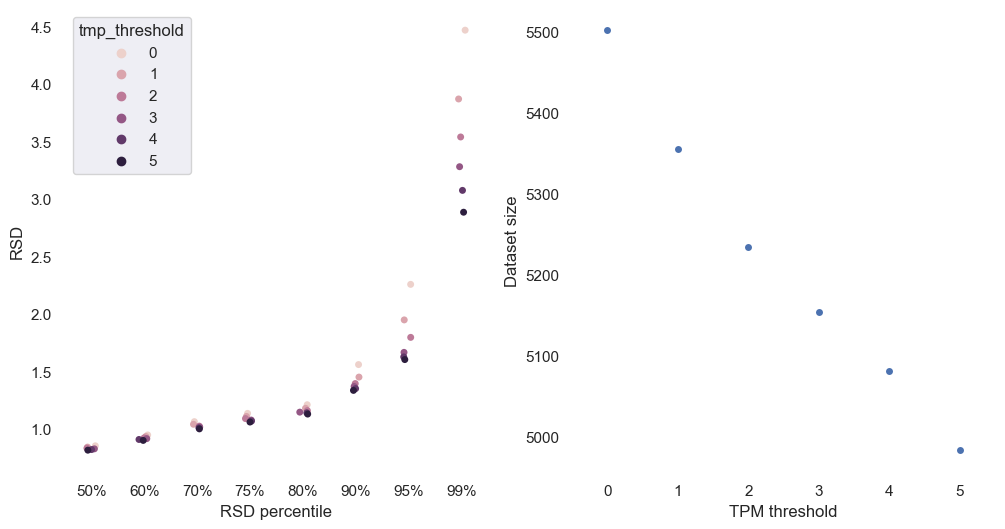

In [ ]:
print(filtered_df_klactis.shape)
print(filtered_df_klactis.head())

def rsd(x): 
    return x.std()/x.mean()

dfs = []
for i in range(0, 6):
    x = pd.DataFrame(filtered_df_klactis.groupby(['geneId']).agg({'TPM' :['median', 'std', rsd]})["TPM"].query('median > {}'.format(i)).rsd.describe(percentiles=[.5, .6, .7, .75, .8, .9, .95, .99])).reset_index()
    x["tmp_threshold"] = i
    dfs.append(x)
    print('TPM > {}'.format(i))
    
tmp_thresholds = pd.concat(dfs)

toPlot = tmp_thresholds[tmp_thresholds["index"].isin(["50%", "60%", "70%", "75%", "80%", "90%", "95%", "99%"])]


fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharex=False, sharey=False)

#g = sns.FacetGrid(toPlot, col='tmp_threshold', col_wrap=3, sharex=False, sharey=False)
sns.set_theme()
sns.stripplot(ax=axes[0], y = "rsd", x="index", hue='tmp_threshold', data=toPlot).set(xlabel="RSD percentile", ylabel="RSD")
sns.stripplot(ax=axes[1], y = "rsd", x="tmp_threshold", data=tmp_thresholds.query('index == "count"')).set(xlabel="TPM threshold", ylabel="Dataset size")


# Remove gridlines and set background to transparent
for ax in axes:
    ax.grid(False)
    ax.set_facecolor('none')

fig.patch.set_alpha(0.0)
plt.show()

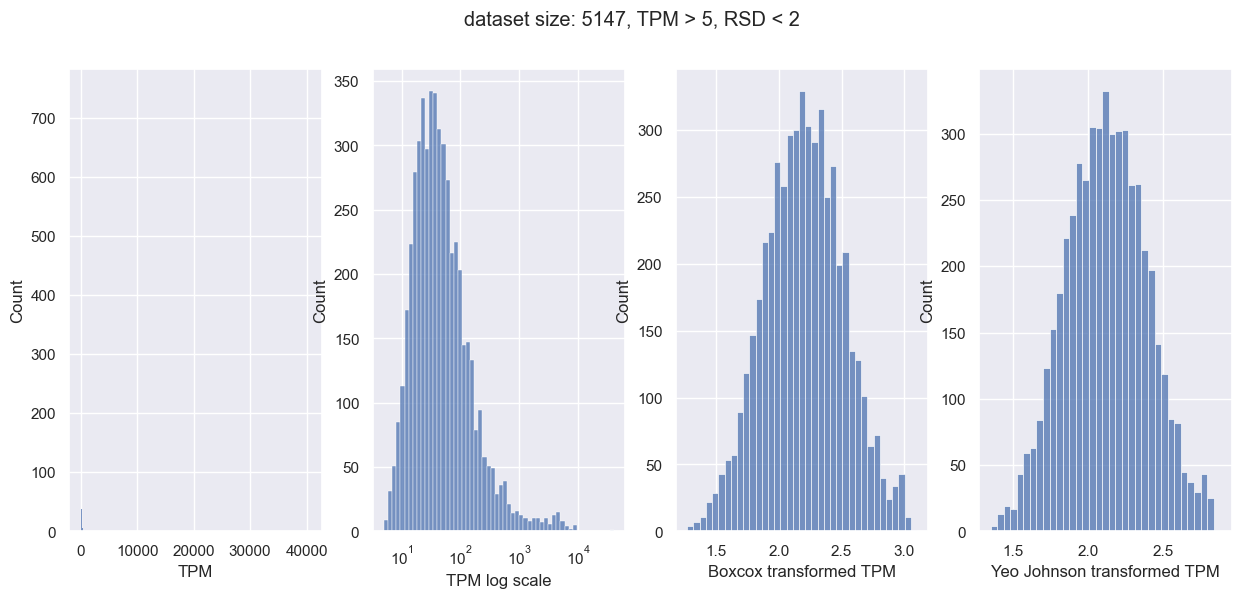

In [9]:

Path("./output_files").mkdir(parents=True, exist_ok=True)

TPM_THRESHOLD = 5
RSD_THRESHOLD = 2

( filtered_df_klactis
    .pipe(filter_tpm_rsd_dataset, TPM_THRESHOLD, RSD_THRESHOLD)
    .pipe(transform_tpm)
    .pipe(plot_transformed, "TPM > {}, RSD < {}".format(TPM_THRESHOLD, RSD_THRESHOLD), "./output_files/klactis_tpm_{}_rsd_{}.tsv".format(TPM_THRESHOLD, RSD_THRESHOLD)))

klactis_tpm_1_rsd_2.tsv
             geneId        TPM  boxcox_tpm  bc_lmbda    yj_tpm  yj_lmbda
0  ENSRNAG049935306   1.166524    0.152274 -0.149002  0.718023 -0.193687
1  ENSRNAG049935308   1.166524    0.152274 -0.149002  0.718023 -0.193687
2  ENSRNAG049935311   4.703146    1.382626 -0.149002  1.477863 -0.193687
3  ENSRNAG049935312   2.185605    0.738064 -0.149002  1.037838 -0.193687
4  ENSRNAG049935314  11.497344    2.047123 -0.149002  1.997338 -0.193687
{'Transformation': ['Box-Cox TPM', 'Yeo-Johnson TPM'], 'Skewness': [-0.038577329515694356, -0.023333533495777645], 'Kurtosis': [0.6374609702680436, 0.3241542700367872]}


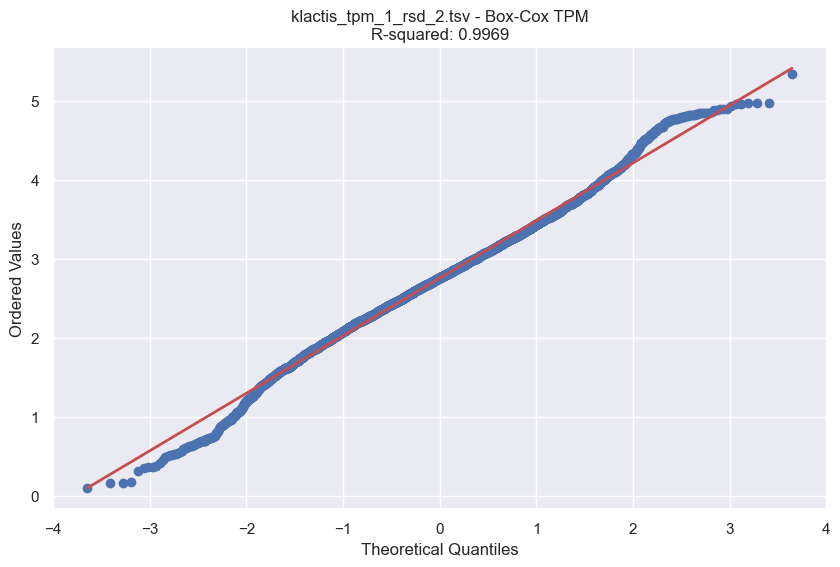

klactis_tpm_1_rsd_1.tsv
             geneId        TPM  boxcox_tpm  bc_lmbda    yj_tpm  yj_lmbda
0  ENSRNAG049935314  11.497344    1.946834 -0.193209  1.906919 -0.233984
1  ENSRNAG049935318   8.641426    1.763688 -0.193209  1.758783 -0.233984
2  ENSRNAG049935322   1.790043    0.550685 -0.193209  0.912181 -0.233984
3  ENSRNAG049935329   6.151343    1.532093 -0.193209  1.576674 -0.233984
4  ENSRNAG049935337   2.345503    0.785993 -0.193209  1.051999 -0.233984
{'Transformation': ['Box-Cox TPM', 'Yeo-Johnson TPM'], 'Skewness': [-0.06202169999736209, -0.04123815383257211], 'Kurtosis': [0.9563001460369325, 0.5793612900786012]}


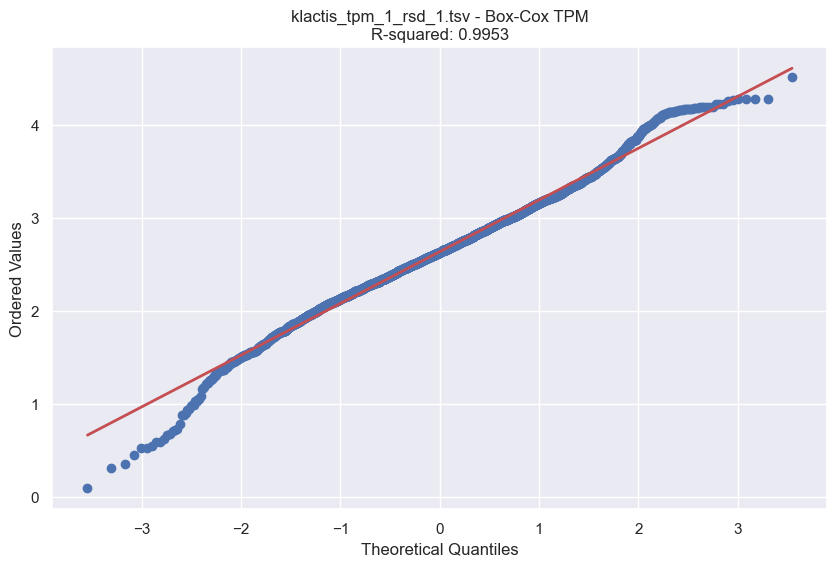

klactis_tpm_0_rsd_1.tsv
             geneId        TPM  boxcox_tpm  bc_lmbda    yj_tpm  yj_lmbda
0  ENSRNAG049935314  11.465580    2.069259 -0.138819  1.979520 -0.200755
1  ENSRNAG049935318   8.014682    1.807593 -0.138819  1.777713 -0.200755
2  ENSRNAG049935322   0.936265   -0.066159 -0.138819  0.618811 -0.200755
3  ENSRNAG049935329   4.766557    1.403953 -0.138819  1.477102 -0.200755
4  ENSRNAG049935337   2.104793    0.707065 -0.138819  1.013343 -0.200755
{'Transformation': ['Box-Cox TPM', 'Yeo-Johnson TPM'], 'Skewness': [-0.10257988921013263, -0.06572767106252586], 'Kurtosis': [2.1790108468503844, 1.0077125034326846]}


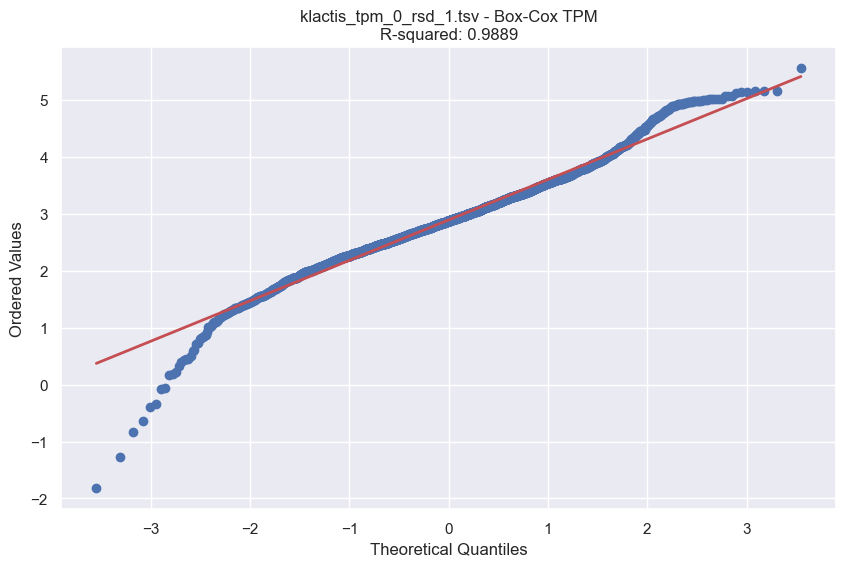

klactis_tpm_5_rsd_2.tsv
             geneId        TPM  boxcox_tpm  bc_lmbda    yj_tpm  yj_lmbda
0  ENSRNAG049935308   6.048109    1.378685 -0.310602  1.430609 -0.337095
1  ENSRNAG049935311  14.453594    1.815109 -0.310602  1.787745 -0.337095
2  ENSRNAG049935314  12.022964    1.732449 -0.310602  1.717746 -0.337095
3  ENSRNAG049935316  18.061677    1.909034 -0.310602  1.868245 -0.337095
4  ENSRNAG049935317   9.097825    1.597940 -0.310602  1.605931 -0.337095
{'Transformation': ['Box-Cox TPM', 'Yeo-Johnson TPM'], 'Skewness': [0.034735285974851364, 0.04725772754591272], 'Kurtosis': [-0.223175176557044, -0.2963027907093476]}


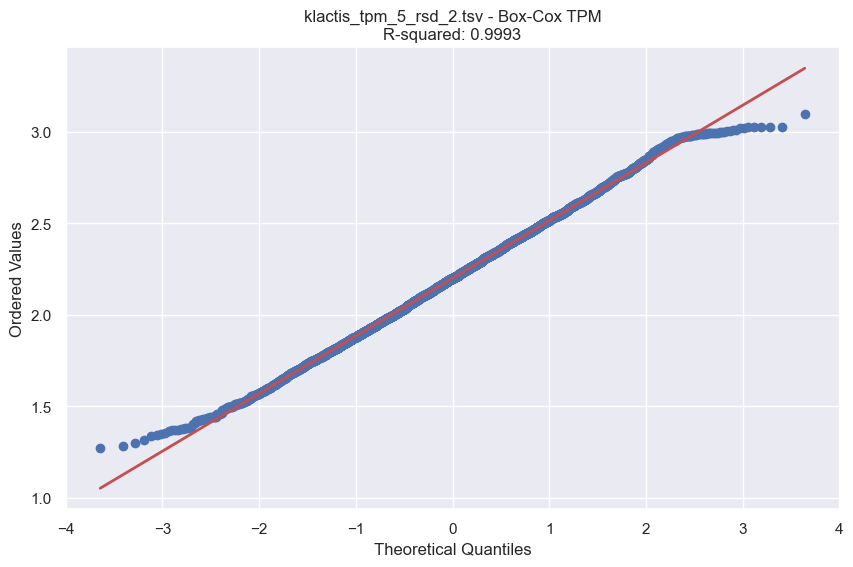

klactis_tpm_5_rsd_1.tsv
             geneId        TPM  boxcox_tpm  bc_lmbda    yj_tpm  yj_lmbda
0  ENSRNAG049935314  12.022964    1.701283 -0.327399  1.687111 -0.353511
1  ENSRNAG049935318   9.443754    1.589972 -0.327399  1.594468 -0.353511
2  ENSRNAG049935322   5.778298    1.334450 -0.327399  1.390674 -0.353511
3  ENSRNAG049935329   8.846654    1.558320 -0.327399  1.568510 -0.353511
4  ENSRNAG049935337   6.556754    1.404166 -0.327399  1.444894 -0.353511
{'Transformation': ['Box-Cox TPM', 'Yeo-Johnson TPM'], 'Skewness': [0.0281612891118773, 0.041203272164774214], 'Kurtosis': [-0.1400413466455137, -0.21853739549620066]}


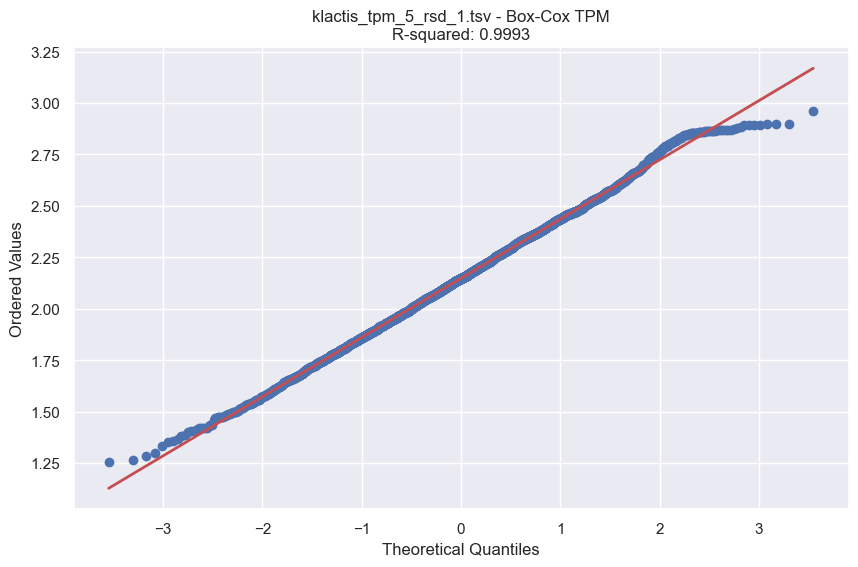

In [38]:
import os
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt

import os
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt

filepath = 'output_files'
files = os.listdir(filepath)

for file in files:
    if file.endswith(".tsv") and file.startswith("klactis"):
        print(file)
        file_path = os.path.join(filepath, file)
        dataset = pd.read_csv(file_path, sep="\t")
        print(dataset.head())

        normalization_metrics = {
            "Transformation": [
                "Box-Cox TPM" if "boxcox_tpm" in dataset.columns else "Box-Cox (Skipped)",
                "Yeo-Johnson TPM"
            ],
            "Skewness": [
                stats.skew(dataset["boxcox_tpm"]) if "boxcox_tpm" in dataset.columns else None,
                stats.skew(dataset["yj_tpm"])
            ],
            "Kurtosis": [
                stats.kurtosis(dataset["boxcox_tpm"], fisher=True) if "boxcox_tpm" in dataset.columns else None,
                stats.kurtosis(dataset["yj_tpm"], fisher=True)
            ]
        }

        print(normalization_metrics)

        # Plot probability plot for Box-Cox TPM
        if "boxcox_tpm" in dataset.columns:
            plt.figure(figsize=(10, 6))
            qq_array = stats.probplot(dataset["boxcox_tpm"], dist="norm", plot=None)
            x, y = qq_array[0]
            slope, intercept, r = qq_array[1]
            plt.plot(x, y, 'o')
            plt.plot(x, slope*x + intercept, 'r', lw=2)
            plt.title(f'{file} - Box-Cox TPM\nR-squared: {r:.4f}')
            plt.xlabel('Theoretical Quantiles')
            plt.ylabel('Ordered Values')
            plt.show()
    
        
    




## Filtering the FungiExp TPM dataset into TPM threshold and RSD threshold 

- The <code>filter_tpm_rsd_dataset_geneId</code> function filters a dataset based on TPM and RSD threshold, sorts the gene IDs by median TPM, and returns the filtered dataset ordered by gene ID. 

- The code applies this function to three datasets (**but you want to do this for all the dataset automatically**). The three datasets are: (`filtered_df_yarrowia`, `filtered_df_polymorpha`, `filtered_df_klactis`), prints the head, shape and unique gene ID count of each dataset.

- Each filtered dataset is save to a CSV file

In [ ]:
def filter_tpm_rsd_dataset_geneId(dataset, tpm_threshold, rsd_threshold):
    gene_stats = dataset.query('TPM > 0').groupby(['geneId']).agg({'TPM' :['sum', 'mean', 'median', 'std', rsd]})
    ge_data_tpm_median = dataset.query('TPM > {}'.format(tpm_threshold)).groupby("geneId").agg({'TPM': 'median'}).reset_index() #filter TPM and get median TPM 
    ge_data_tpm_median_rsd = ge_data_tpm_median[ge_data_tpm_median["geneId"].isin(gene_stats["TPM"].query('rsd < {}'.format(rsd_threshold)).index)] #filter geneIds based on RSD
    ge_data_tpm_median_rsd = ge_data_tpm_median_rsd.sort_values(by="TPM", ascending=True)

    # Get the sorted geneIds that passed filtering
    sorted_kept_geneIds = ge_data_tpm_median_rsd["geneId"].tolist()

    # Filter original dataset by the sorted geneIds and maintain the order
    filtered_dataset = dataset[dataset["geneId"].isin(sorted_kept_geneIds)]
    
    # Ensure dataset is ordered by geneId as per sorted median TPM
    filtered_dataset["geneId"] = pd.Categorical(filtered_dataset["geneId"], categories=sorted_kept_geneIds, ordered=True)
    filtered_dataset = filtered_dataset.sort_values(by="geneId")

    return filtered_dataset



In [ ]:
## EXAMPLE OF HOW TO USE IT 
# Gets head, shape and unique geneID count

filtered_df_yarrowia_tpm_rsd = filter_tpm_rsd_dataset_geneId(filtered_df_yarrowia, 5, 1) 
print(filtered_df_yarrowia_tpm_rsd.head())
print(filtered_df_yarrowia_tpm_rsd.shape)
print(filtered_df_yarrowia_tpm_rsd["geneId"].nunique())
filtered_df_yarrowia_tpm_rsd.to_csv("filtered_df_yarrowia_tpm_5_rsd_1_order.csv", sep=",", index=False)

filtered_df_polymorpha_tpm_rsd = filter_tpm_rsd_dataset_geneId(filtered_df_polymorpha, 5, 1) 
print(filtered_df_polymorpha_tpm_rsd.head())
print(filtered_df_polymorpha_tpm_rsd.shape)
print(filtered_df_polymorpha_tpm_rsd["geneId"].nunique())
filtered_df_polymorpha_tpm_rsd.to_csv("filtered_df_polymorpha_tpm_5_rsd_1_order.csv", sep=",", index=False)


filtered_df_klactis_tpm_rsd = filter_tpm_rsd_dataset_geneId(filtered_df_klactis, 5, 1) 
print(filtered_df_klactis_tpm_rsd.head())
print(filtered_df_klactis_tpm_rsd.shape)
print(filtered_df_klactis_tpm_rsd["geneId"].nunique())
filtered_df_klactis_tpm_rsd.to_csv("filtered_df_klactis_tpm_5_rsd_1_order.csv", sep=",", index=False)



/var/folders/7x/7scxxbdj6fz3w64qtgzb5pxm0000gn/T/ipykernel_45355/2365706896.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_dataset["geneId"] = pd.Categorical(filtered_dataset["geneId"], categories=sorted_kept_geneIds, ordered=True)


                geneId       TPM                taxon
256182   YALI0_F20922g  3.845331  Yarrowia lipolytica
459970   YALI0_F20922g  0.483558  Yarrowia lipolytica
1608378  YALI0_F20922g  0.223830  Yarrowia lipolytica
539866   YALI0_F20922g  0.210127  Yarrowia lipolytica
1529196  YALI0_F20922g  0.574785  Yarrowia lipolytica
(1556910, 3)
4749


/var/folders/7x/7scxxbdj6fz3w64qtgzb5pxm0000gn/T/ipykernel_45355/2365706896.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_dataset["geneId"] = pd.Categorical(filtered_dataset["geneId"], categories=sorted_kept_geneIds, ordered=True)


                   geneId       TPM               taxon
2286710  OGAPODRAFT_51709  2.665045  Ogataea polymorpha
2215183  OGAPODRAFT_51709  0.418878  Ogataea polymorpha
2372889  OGAPODRAFT_51709  0.271543  Ogataea polymorpha
2226112  OGAPODRAFT_51709  1.432448  Ogataea polymorpha
2228669  OGAPODRAFT_51709  0.445280  Ogataea polymorpha
(241544, 3)
3703


/var/folders/7x/7scxxbdj6fz3w64qtgzb5pxm0000gn/T/ipykernel_45355/2365706896.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_dataset["geneId"] = pd.Categorical(filtered_dataset["geneId"], categories=sorted_kept_geneIds, ordered=True)


                geneId       TPM                 taxon
2599082  KLLA0_F17198g  5.037247  Kluyveromyces lactis
2551790  KLLA0_F17198g  1.585096  Kluyveromyces lactis
2665490  KLLA0_F17198g  2.859703  Kluyveromyces lactis
2609677  KLLA0_F17198g  2.261961  Kluyveromyces lactis
2636439  KLLA0_F17198g  2.329221  Kluyveromyces lactis
(222147, 3)
3552


- The code reads a FASTA file containing CDS into a dictionary, then loads a CSV file with gene expression data.
- maps CDS geneId with geneId in .csv file --> calculates length for each CDS and puts that into a column.


In [13]:
import pandas as pd
import os 
import scipy.stats
import numpy as np
import sklearn
from sklearn.linear_model import LinearRegression

species_name = "Ogataea_polymorpha"
sequence_name = "Ogataea_polymorpha_gca_001664045"
TPM_THRESHOLD = 5
RSD_THRESHOLD = 1 
directory = f"output_residual_boxcox_TPM/{species_name}"

# Function to read FASTA files into a dictionary
def read_fasta_manual(file_path):
    fasta_dict = {}
    with open(file_path, "r") as f:
        gene_id = None
        sequence = []
        for line in f:
            line = line.strip()
            if line.startswith(">"):  # New sequence header
                if gene_id:  # Save the previous gene
                    fasta_dict[gene_id] = "".join(sequence)
                gene_id = line[1:]  # Remove '>' to get geneId
                sequence = []  # Reset sequence list
            else:
                sequence.append(line)
        if gene_id:  # Save the last sequence
            fasta_dict[gene_id] = "".join(sequence)
    return fasta_dict

# Find the CSV file with the same species name
csv_file_name = f"{species_name}_tpm_{TPM_THRESHOLD}_rsd_{RSD_THRESHOLD}.csv"
csv_file_path = os.path.join(directory, csv_file_name) 
cds_fasta_path = f"/Users/marcamil/PhD/PhD_SyntheticGenomes/Projects/Transcriptional_unit_design_in_yeast/data/AGAT_sequences/{sequence_name}/{sequence_name}_CDS_sequences.fasta"
upstream_fasta_path = f"/Users/marcamil/PhD/PhD_SyntheticGenomes/Projects/Transcriptional_unit_design_in_yeast/data/AGAT_sequences/{sequence_name}/{sequence_name}_CDS_up_1000.fasta"
downstream_fasta_path = f"/Users/marcamil/PhD/PhD_SyntheticGenomes/Projects/Transcriptional_unit_design_in_yeast/data/AGAT_sequences/{sequence_name}/{sequence_name}_CDS_down_1000.fasta"


# Read sequences from fasta files manually
cds_sequences = read_fasta_manual(cds_fasta_path)
upstream_sequences = read_fasta_manual(upstream_fasta_path)
downstream_sequences = read_fasta_manual(downstream_fasta_path)

# Load CSV file
df = pd.read_csv(csv_file_path)
df["CDS"] = df["geneId"].map(cds_sequences)
df["gene_len"] = df["CDS"].apply(lambda x: len(x) if pd.notnull(x) else 0)
df = df.drop(columns=["CDS"]).query("gene_len > 0")[["geneId", "TPM", "gene_len"]]

### Calculates residual_boxcox_TPM section

print(df.head())


df["boxcox_TPM"] = scipy.stats.boxcox(df["TPM"], lmbda=0.22)
gene_lengths = np.array(df["gene_len"]).reshape(-1, 1)
df["residual_boxcox_TPM"] = df["boxcox_TPM"] - sklearn.linear_model.LinearRegression().fit(y=df["boxcox_TPM"], X=gene_lengths).predict(X=gene_lengths)
df = df.groupby('geneId')[["residual_boxcox_TPM", "boxcox_TPM", "TPM"]].median().reset_index()


# Add sequences to dataframe
df["CDS"] = df["geneId"].map(cds_sequences)
df["upstream_seq"] = df["geneId"].map(upstream_sequences)
df["downstream_seq"] = df["geneId"].map(downstream_sequences)

# Modify downstream_seq by prepending the last three letters of the CDS sequence
df["downstream_seq"] = df.apply(lambda row: row["CDS"][-3:] + row["downstream_seq"] if pd.notnull(row["downstream_seq"]) else row["downstream_seq"], axis=1)
# Add "ATG" to the end of all sequences in the upstream_seq
df["upstream_seq"] = df["upstream_seq"].apply(lambda seq: seq + "ATG" if pd.notnull(seq) else seq)

# Save updated CSV file
output_csv_path = os.path.join(directory, f"{species_name}_TPM_{TPM_THRESHOLD}_RSD_{RSD_THRESHOLD}_residuals_CDS_upstream_downstream.csv")
df.to_csv(output_csv_path, index=False)
print(f"Updated file saved as: {output_csv_path}")



             geneId       TPM  gene_len
0  OGAPODRAFT_51709  2.665045      1773
1  OGAPODRAFT_51709  0.418878      1773
2  OGAPODRAFT_51709  0.271543      1773
3  OGAPODRAFT_51709  1.432448      1773
4  OGAPODRAFT_51709  0.445280      1773
Updated file saved as: output_residual_boxcox_TPM/Ogataea_polymorpha/Ogataea_polymorpha_TPM_5_RSD_1_residuals_CDS_upstream_downstream.csv


## Visualising the dataset 

./output_residual_boxcox_TPM/Ogataea_polymorpha/Ogataea_polymorpha_TPM_5_RSD_1_residuals_CDS_upstream_downstream.csv
./output_residual_boxcox_TPM/Yarrowia_lipolytica/Yarrowia_lipolytica_TPM_5_RSD_1_residuals_CDS_upstream_downstream.csv
./output_residual_boxcox_TPM/Kluyveromyces_lactis/Kluyveromyces_lactis_TPM_5_RSD_1_residuals_CDS_upstream_downstream.csv
                  geneId  residual_boxcox_TPM  boxcox_TPM          TPM  \
0      OGAPODRAFT_100017            -1.854723    5.531809    37.311392   
1      OGAPODRAFT_100078             6.942664   14.360815   651.290222   
2      OGAPODRAFT_100096            18.962772   26.461022  6171.127197   
3      OGAPODRAFT_100117            -1.473833    4.763907    26.013180   
4      OGAPODRAFT_100144             0.349380    7.649489    88.872535   
...                  ...                  ...         ...          ...   
11890      KLLA0_F27973g            -0.866462    6.327160    52.677032   
11891      KLLA0_F28017g            -2.391281    4.

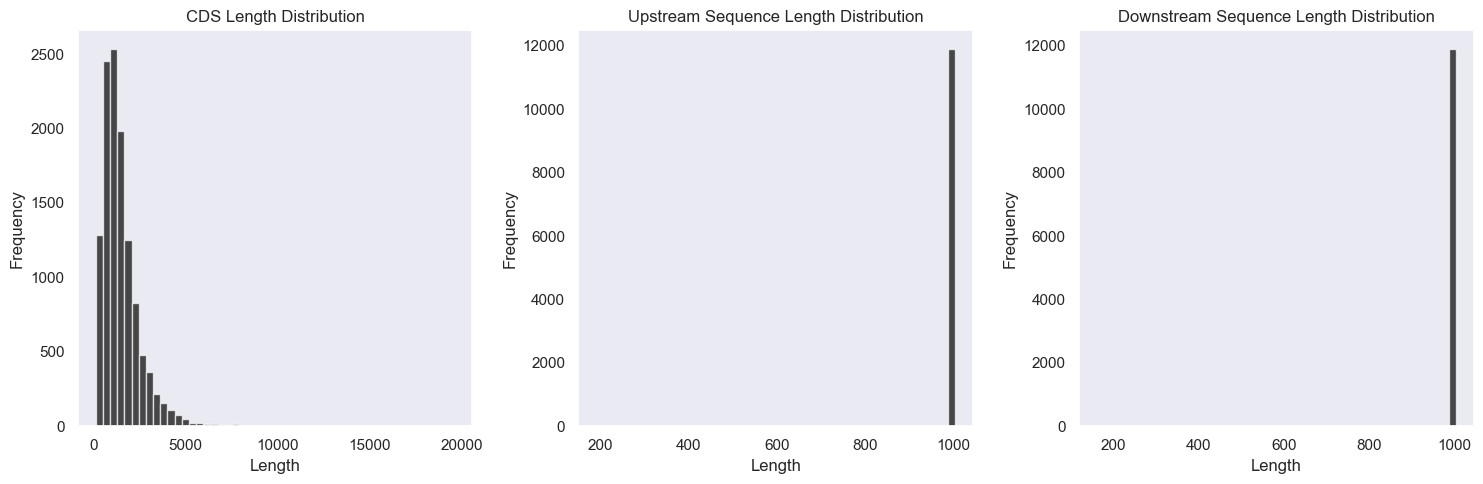

In [14]:
directory_cds_downstream_upstream = "./output_residual_boxcox_TPM"

dataframes = []

# Walk through the directory
for root, dirs, files in os.walk(directory_cds_downstream_upstream):
    for file in files:
        if file.endswith('_CDS_upstream_downstream.csv'):
            file_path = os.path.join(root, file)
            print(file_path)
            # Read the CSV file and append to the list
            df = pd.read_csv(file_path)
            dataframes.append(df)

# Concatenate all DataFrames
combined_df = pd.concat(dataframes, ignore_index=True)

# Display the combined DataFrame
print(combined_df)
print(combined_df.shape)
print(combined_df.columns)

# Assuming combined_df is the DataFrame from the previous step
# Calculate the lengths of CDS, upstream_seq, and downstream_seq
combined_df['CDS_length'] = combined_df['CDS'].apply(len)
combined_df['upstream_length'] = combined_df['upstream_seq'].apply(len)
combined_df['downstream_length'] = combined_df['downstream_seq'].apply(len)

# Plot histograms
plt.figure(figsize=(15, 5))

# Histogram for CDS length
plt.subplot(1, 3, 1)
plt.hist(combined_df['CDS_length'], bins=50, color='black', alpha=0.7)
plt.title('CDS Length Distribution')
plt.xlabel('Length')
plt.ylabel('Frequency')
plt.grid(False)

# Histogram for upstream sequence length
plt.subplot(1, 3, 2)
plt.hist(combined_df['upstream_length'], bins=50, color='black', alpha=0.7)
plt.title('Upstream Sequence Length Distribution')
plt.xlabel('Length')
plt.ylabel('Frequency')
plt.grid(False)

# Histogram for downstream sequence length
plt.subplot(1, 3, 3)
plt.hist(combined_df['downstream_length'], bins=50, color='black', alpha=0.7)
plt.title('Downstream Sequence Length Distribution')
plt.xlabel('Length')
plt.ylabel('Frequency')
plt.grid(False)

# Adjust layout and show plot
plt.tight_layout()
plt.show()
